In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

# Re-Implementation of Derived Distance and Radial Velocity for Gaia DR3 stars

Given the expressions for the implied distance D and radial velocity $V_r$:

$D = \frac{ \hat{n} \cdot (\vec{R_{0}} \times \vec{V_{0}})}{\vec{R_ 0} \
\cdot (\hat{n} \times \vec{\mu})}$

$V_r = \frac{D \vec{V_ 0} \cdot (\hat{n} \times \vec{\mu}) - \vec{\mu} \
\cdot (\vec{R_ 0} \times \vec{V_o})}{\vec{R_ 0} \cdot (\hat{n} \times \
\vec{\mu})}$

In [45]:
# Sills Implementation

class constant:
    masyr = u.mas / u.year
    radyr = u.rad / u.year
    kms = u.km / u.s
    mult = (1 * masyr).to_value(radyr) / u.year
    inv_kpc = 1 / u.kpc

def getdist(ra, dec, pmra, pmdec, epmra=0, epmdec=0):
    """ Get distance assuming GC origin
    Return
    1) plx (mas)
    2) plx uncertainty (mas),
    3) implied galactocentric radial velocity (km/s)
    4) Implied radial velocity (km/s)
    """
    # GC position in rectangular ICRS system
    X0 = coord.Galactocentric(x=0 * u.kpc,
                             y=0 * u.kpc,
                             z=0 * u.kpc,
                             v_x=0 * constant.kms,
                             v_y=0 * constant.kms,
                             v_z=0 * constant.kms).transform_to(
                                 coord.ICRS()).represent_as(
                                     coord.CartesianRepresentation)
    DX0 = X0.differentials['s']

    R0 = -u.Quantity([X0.x, X0.y, X0.z])
    # vector pointing from GC to the Sun in the ICRS rectangular system

    V0 = -u.Quantity([DX0.d_x, DX0.d_y, DX0.d_z])
    # Sun's velocity vector in the ICRS rectangular system

    # Convert sky position to units of rad
    ra_r = np.deg2rad(ra)
    dec_r = np.deg2rad(dec)

    # vector pointing to the star
    n = [
        np.cos(ra_r) * np.cos(dec_r),
        np.sin(ra_r) * np.cos(dec_r),
        np.sin(dec_r)
    ]

    # cross product of R0 and n
    R0n = u.Quantity([
        n[1] * R0[2] - n[2] * R0[1], -(n[0] * R0[2] - n[2] * R0[0]),
        n[0] * R0[1] - n[1] * R0[0]
    ])

    # pmra basis vector
    e1 = [-np.sin(ra_r), np.cos(ra_r), 0]
    # pmdec basis vector
    e2 = [
        -np.cos(ra_r) * np.sin(dec_r), -np.sin(ra_r) * np.sin(dec_r),
        np.cos(dec_r)
    ]

    pmra_u = pmra * constant.mult
    pmdec_u = pmdec * constant.mult
    epmra_u = epmra * constant.mult
    epmdec_u = epmdec * constant.mult
    # proper motions and errors in year^-1 (ie rad/year)
    # I ignore correlations in errors

    mu = [
        pmra_u * e1[0] + pmdec_u * e2[0],
        pmra_u * e1[1] + pmdec_u * e2[1],
        pmra_u * e1[2] + pmdec_u * e2[2]
    ]

    # proper motion vector in rectangular ICRS system
    
    def DOT(x, y):
        return x[0] * y[0] + x[1] * y[1] + x[2] * y[2]


    # here we use the fact that det(ABC) = A . (B x C)
    # and that plx = -det(mu R0 n)/det(V0 R0 n)
    dot_V0_R0n = DOT(V0, R0n)
    plx = -DOT(mu, R0n) / dot_V0_R0n
    eplx = np.sqrt(
        DOT(e1, R0n)**2 * epmra_u**2 + DOT(e2, R0n)**2 * epmdec_u**2) / \
                                                                    dot_V0_R0n

    R02 = DOT(R0, R0)
    V0R0 = DOT(V0, R0)
    nV0 = DOT(V0, n)
    nR0 = DOT(R0, n)
    mun = DOT(mu, n)
    muR0 = DOT(mu, R0)

    D = 1. / plx
    # This is just the result of some algebra of first
    # cross producting the R x V
    # and then dot product the result with (n x R0)
    VR = -1 / (R02 - nR0**2) * (
        (nV0 * R02 - V0R0 * nR0) + D *
        (nV0 * nR0 - V0R0 + mun * R02 - muR0 * nR0) + D**2 *
        (mun * nR0 - muR0))

    # dot product of (V . R)/||R||
    # This is galactocentric radial velocity (total velocity with the sign)
    VGCR = (V0R0 + D * muR0 + VR * nR0 + D * nV0 + D**2 * mun +
            D * VR) / np.sqrt(R02 + D**2 + 2 * D * nR0)
    # Vtot = np.sqrt((V0[0] + VR * n[0] + mu[0] * D)**2 +
    #               (V0[1] + VR * n[1] + mu[1] * D)**2 +
    #               (V0[2] + VR * n[2] + mu[2] * D)**2)
    plx = plx.to_value(constant.inv_kpc)
    eplx = eplx.to_value(constant.inv_kpc)
    return plx, eplx, VGCR.to_value(constant.kms), VR.to_value(constant.kms)


In [4]:
# Example usage with Gaia data:
# Replace these values with actual Gaia data
ra = 56.75  # degrees
dec = 24.1167  # degrees
pmra = 5.0  # mas/yr
pmdec = -3.0  # mas/yr
pmra_err = 0.1  # mas/yr
pmdec_err = 0.1  # mas/yr

D, Vr = compute_D_Vr(ra, dec, pmra, pmdec, pmra_err, pmdec_err)
print(f"Implied Distance D: {D:.2f} pc")
print(f"Implied Radial Velocity V_r: {Vr:.2f} km/s")

Implied Distance D: 32341.38 pc
Implied Radial Velocity V_r: 458.22 km/s


In [23]:
getdist(ra, dec, pmra, pmdec, epmra=pmra_err, epmdec=pmdec_err)

(np.float64(0.09289273851574019),
 np.float64(0.002151233713282953),
 np.float64(486.10054234318346),
 np.float64(438.5940028401289))

## Test new implementation

In [48]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from numba import njit

def compute_R0_V0_SI():
    # Define the position and velocity of the Galactic Center in Galactocentric frame
    # Here, we're using the position of the Sun in the Galactocentric frame,
    # which by definition is at (x, y, z) = (0, 0, 0) in Galactocentric coordinates.
    # We then transform this to the ICRS frame to get the position and velocity vectors.
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=0 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters
    V0 = icrs_coord.velocity.d_xyz.to(u.m / u.s).value  # velocity in m/s

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    R0 = -X0  # Shape (3,)
    V0 = -V0  # Shape (3,)
    return R0, V0

@njit
def getdist_numba(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s,
                  epmra_rad_s, epmdec_rad_s, R0, V0):
    N = len(ra_rad)
    plx = np.empty(N)
    eplx = np.empty(N)
    VGCR = np.empty(N)
    VR = np.empty(N)

    R02 = np.sum(R0**2)
    V0R0 = np.dot(V0, R0)

    for i in range(N):
        ra_r = ra_rad[i]
        dec_r = dec_rad[i]

        cos_ra = np.cos(ra_r)
        sin_ra = np.sin(ra_r)
        cos_dec = np.cos(dec_r)
        sin_dec = np.sin(dec_r)

        n0 = cos_ra * cos_dec
        n1 = sin_ra * cos_dec
        n2 = sin_dec

        # Cross product of R0 and n
        R0n0 = n1 * R0[2] - n2 * R0[1]
        R0n1 = - (n0 * R0[2] - n2 * R0[0])
        R0n2 = n0 * R0[1] - n1 * R0[0]

        # pmra basis vector
        e10 = -sin_ra
        e11 = cos_ra
        e12 = 0.0

        # pmdec basis vector
        e20 = -cos_ra * sin_dec
        e21 = -sin_ra * sin_dec
        e22 = cos_dec

        # proper motions in rad/s (already converted)
        mu0 = pmra_rad_s[i] * e10 + pmdec_rad_s[i] * e20
        mu1 = pmra_rad_s[i] * e11 + pmdec_rad_s[i] * e21
        mu2 = pmra_rad_s[i] * e12 + pmdec_rad_s[i] * e22

        # DOT products
        dot_V0_R0n = V0[0] * R0n0 + V0[1] * R0n1 + V0[2] * R0n2
        dot_mu_R0n = mu0 * R0n0 + mu1 * R0n1 + mu2 * R0n2

        plx_i = - dot_mu_R0n / dot_V0_R0n  # Units: 1/m

        # Compute eplx
        dot_e1_R0n = e10 * R0n0 + e11 * R0n1 + e12 * R0n2
        dot_e2_R0n = e20 * R0n0 + e21 * R0n1 + e22 * R0n2

        eplx_i = np.sqrt(
            (dot_e1_R0n * epmra_rad_s[i])**2 + (dot_e2_R0n * epmdec_rad_s[i])**2
        ) / dot_V0_R0n  # Units: 1/m

        # Compute other DOT products
        nV0 = V0[0] * n0 + V0[1] * n1 + V0[2] * n2
        nR0 = R0[0] * n0 + R0[1] * n1 + R0[2] * n2
        mun = mu0 * n0 + mu1 * n1 + mu2 * n2
        muR0 = mu0 * R0[0] + mu1 * R0[1] + mu2 * R0[2]

        D = 1.0 / plx_i  # Units: m

        denom = R02 - nR0**2
        VR_i = -1 / denom * (
            (nV0 * R02 - V0R0 * nR0) + D *
            (nV0 * nR0 - V0R0 + mun * R02 - muR0 * nR0) + D**2 *
            (mun * nR0 - muR0)
        )  # Units: m/s

        # Compute VGCR
        numerator = V0R0 + D * muR0 + VR_i * nR0 + D * nV0 + D**2 * mun + D * VR_i
        R = np.sqrt(R02 + D**2 + 2 * D * nR0)
        VGCR_i = numerator / R  # Units: m/s

        plx[i] = plx_i  # Units: 1/m
        eplx[i] = eplx_i  # Units: 1/m
        VGCR[i] = VGCR_i  # Units: m/s
        VR[i] = VR_i  # Units: m/s

    return plx, eplx, VGCR, VR

def test_functions():
    # Create test data
    ra_test_deg = np.array([10.684, 56.75])  # degrees
    dec_test_deg = np.array([41.269, 24.116])  # degrees
    pmra_test = np.array([5.25, -3.12])  # mas/yr
    pmdec_test = np.array([-2.16, 4.58])  # mas/yr
    epmra_test = np.array([0.5, 0.3])  # mas/yr
    epmdec_test = np.array([0.4, 0.2])  # mas/yr

    # Convert positions to radians
    ra_rad = np.deg2rad(ra_test_deg)
    dec_rad = np.deg2rad(dec_test_deg)

    # Convert proper motions to radians per second
    masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
    pmra_rad_s = pmra_test * masyr_to_radsec
    pmdec_rad_s = pmdec_test * masyr_to_radsec
    epmra_rad_s = epmra_test * masyr_to_radsec
    epmdec_rad_s = epmdec_test * masyr_to_radsec

    # Compute R0 and V0 in SI units (meters and meters per second)
    R0_SI, V0_SI = compute_R0_V0_SI()

    # Run optimized function
    plx_opt, eplx_opt, VGCR_opt, VR_opt = getdist_numba(
        ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI
    )

    # Convert plx and eplx from 1/m to mas
    plx_mas = (plx_opt * u.m**-1).to(1/u.pc, equivalencies=u.parallax())*1e3
    eplx_mas = (eplx_opt * u.m**-1).to(1/u.pc, equivalencies=u.parallax())*1e3

    # VGCR and VR are in m/s, convert to km/s
    VGCR_kms = VGCR_opt / 1e3
    VR_kms = VR_opt / 1e3

    # Print the outputs
    print("Parallax (mas):", plx_mas.value)
    print("Parallax error (mas):", eplx_mas.value)
    print("VGCR (km/s):", VGCR_kms)
    print("VR (km/s):", VR_kms)

    # compare time it takes to run the optimized function
    plx, eplx, vgcr,  vr = getdist(ra_test_deg, dec_test_deg, pmra_test, pmdec_test, epmra_test, epmdec_test)

    print("Previous Implementation:")
    print('plx:', plx)
    print('eplx:', eplx)
    print('vgcr:', vgcr)
    print('vr:', vr)

if __name__ == "__main__":
    test_functions()


Parallax (mas): [ 0.14703151 -0.11372919]
Parallax error (mas): [0.01752552 0.00452187]
VGCR (km/s): [ 52.69610389 -36.38865661]
VR (km/s): [-142.45640088  -23.55448076]
Previous Implementation:
plx: [ 0.14703151 -0.11372919]
eplx: [0.01752552 0.00452187]
vgcr: [ 52.69610389 -36.38865661]
vr: [-142.45640088  -23.55448076]


In [50]:
# compare time it takes to run the optimized function to the previous implementation
import time
# Create test data
ra_test_deg = np.array([10.684, 56.75])  # degrees
dec_test_deg = np.array([41.269, 24.116])  # degrees
pmra_test = np.array([5.25, -3.12])  # mas/yr
pmdec_test = np.array([-2.16, 4.58])  # mas/yr
epmra_test = np.array([0.5, 0.3])  # mas/yr
epmdec_test = np.array([0.4, 0.2])  # mas/yr

# Convert positions to radians
ra_rad = np.deg2rad(ra_test_deg)
dec_rad = np.deg2rad(dec_test_deg)

# Convert proper motions to radians per second
masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
pmra_rad_s = pmra_test * masyr_to_radsec
pmdec_rad_s = pmdec_test * masyr_to_radsec
epmra_rad_s = epmra_test * masyr_to_radsec
epmdec_rad_s = epmdec_test * masyr_to_radsec

# Compute R0 and V0 in SI units (meters and meters per second)
R0_SI, V0_SI = compute_R0_V0_SI()


# check time for previous implementation
start_time_sill = time.time()
getdist(ra_test_deg, dec_test_deg, pmra_test, pmdec_test, epmra_test, epmdec_test)
sills_implementation_time =  time.time() - start_time_sill
print("Time for previous implementation:", sills_implementation_time )

# check time for optimized implementation
start_time = time.time()
# Run optimized function
plx_opt, eplx_opt, VGCR_opt, VR_opt = getdist_numba(
    ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI)
optimized_implementation_time = time.time() - start_time
print("Time for optimized implementation:", optimized_implementation_time)
print("Speedup:", sills_implementation_time/optimized_implementation_time)

Time for previous implementation: 0.006140232086181641
Time for optimized implementation: 8.678436279296875e-05
Speedup: 70.75274725274726


## Test on Sill's candidate list

In [108]:
# Test with Sill's already computed stars
# Load the data
sills_candidates = pd.read_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/full_candidate_list.txt")

# Query Gaia DR3 for the parallax and proper motions
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u

source_ids_sills_candidates = sills_candidates["GaiaDR3_source_id"].values
source_ids_str = ','.join(str(id) for id in source_ids_sills_candidates)


# Connect to Gaia
job = Gaia.launch_job_async(f"SELECT * \
                             FROM gaiaedr3.gaia_source \
                             WHERE source_id IN ({source_ids_str}) \
                            ")

# Get the results
gaia_results = job.get_results()
gaia_results = gaia_results.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]


In [109]:
# merge sills candidates and gaia data on source_id
gaia_results = sills_candidates.merge(gaia_results, left_on="GaiaDR3_source_id", right_on="source_id", how="inner", suffixes=("", ""))

In [110]:
gaia_results

,GaiaDR3_source_id,Vr,D,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,...,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
0,711591182331043328,841.362053,19.188610,1636042515805110273,Gaia EDR3 711591182331043328,711591182331043328,662665914,2016.0,134.743864,0.225300,...,NaN,NaN,0,NaN,NaN,NaN,194.699724,39.494272,128.520817,12.670738
1,6408940170344856320,885.037916,15.533784,1636042515805110273,Gaia EDR3 6408940170344856320,6408940170344856320,1532697719,2016.0,328.710865,0.066008,...,NaN,NaN,0,NaN,NaN,NaN,329.987206,-44.502238,304.740925,-45.698303
2,3708419108627830784,962.591200,22.734554,1636042515805110273,Gaia EDR3 3708419108627830784,3708419108627830784,330206467,2016.0,189.055567,0.270498,...,NaN,NaN,0,NaN,NaN,NaN,292.397611,68.857829,185.811178,9.373780
3,16647293239608960,804.661059,6.619783,1636042515805110273,Gaia EDR3 16647293239608960,16647293239608960,332186407,2016.0,51.653454,0.221758,...,NaN,NaN,0,NaN,NaN,NaN,172.049157,-35.808997,52.313941,-6.699232
4,6694192519250537216,1317.383159,20.990844,1636042515805110273,Gaia EDR3 6694192519250537216,6694192519250537216,589324171,2016.0,304.609144,0.167424,...,NaN,NaN,0,NaN,NaN,NaN,3.905775,-32.642007,298.160939,-17.442421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,6526957316064825600,739.639195,13.857838,1636042515805110273,Gaia EDR3 6526957316064825600,6526957316064825600,131829054,2016.0,349.287403,0.400392,...,NaN,NaN,0,NaN,NaN,NaN,336.919574,-61.792761,327.646248,-39.779550
596,645649999677810560,992.560038,21.114783,1636042515805110273,Gaia EDR3 645649999677810560,645649999677810560,84835703,2016.0,141.788300,0.303405,...,NaN,NaN,0,NaN,NaN,NaN,203.081824,44.475062,136.106481,9.811670
597,3682641333392082304,1308.634473,28.561044,1636042515805110273,Gaia EDR3 3682641333392082304,3682641333392082304,1371144391,2016.0,191.632296,0.285166,...,NaN,NaN,0,NaN,NaN,NaN,300.426926,60.681530,191.542994,2.605852
598,791351439438425472,908.420323,17.697420,1636042515805110273,Gaia EDR3 791351439438425472,791351439438425472,1372038513,2016.0,177.549252,0.039747,...,NaN,NaN,0,NaN,NaN,NaN,144.050845,62.930671,151.549615,45.120645


In [111]:
# compute the distance and radial velocity with my implementation

# Create test data
ra_test_deg = gaia_results['ra'].values # degrees
dec_test_deg = gaia_results['dec'].values # degrees
pmra_test = gaia_results['pmra'].values  # mas/yr
pmdec_test = gaia_results['pmdec'].values  # mas/yr
epmra_test = gaia_results['pmra_error'].values # mas/yr
epmdec_test = gaia_results['pmra_error'].values  # mas/yr

# Convert positions to radians
ra_rad = np.deg2rad(ra_test_deg)
dec_rad = np.deg2rad(dec_test_deg)

# Convert proper motions to radians per second
masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
pmra_rad_s = pmra_test * masyr_to_radsec
pmdec_rad_s = pmdec_test * masyr_to_radsec
epmra_rad_s = epmra_test * masyr_to_radsec
epmdec_rad_s = epmdec_test * masyr_to_radsec



plx_opt, eplx_opt, VGCR_opt, VR_opt = getdist_numba(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI)


# Convert plx and eplx from 1/m to mas
plx_mas = (plx_opt * u.m**-1).to(1/u.pc, equivalencies=u.parallax())*1e3
eplx_mas = (eplx_opt * u.m**-1).to(1/u.pc, equivalencies=u.parallax())*1e3

# VGCR and VR are in m/s, convert to km/s
VGCR_kms = VGCR_opt / 1e3
VR_kms = VR_opt / 1e3

In [112]:
# compute distance and radial velocity with Sill'set
plx_sill, eplx_sill, VGCR_sill, VR_sill = getdist(ra_test_deg, dec_test_deg, pmra_test, pmdec_test, epmra=epmra_test, epmdec=epmdec_test)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_95654/2350583531.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$ \overline{ \omega}$ Sill list (mas)')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_95654/2350583531.py:5: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$ \overline{ \omega}$ Our implementation (mas)')


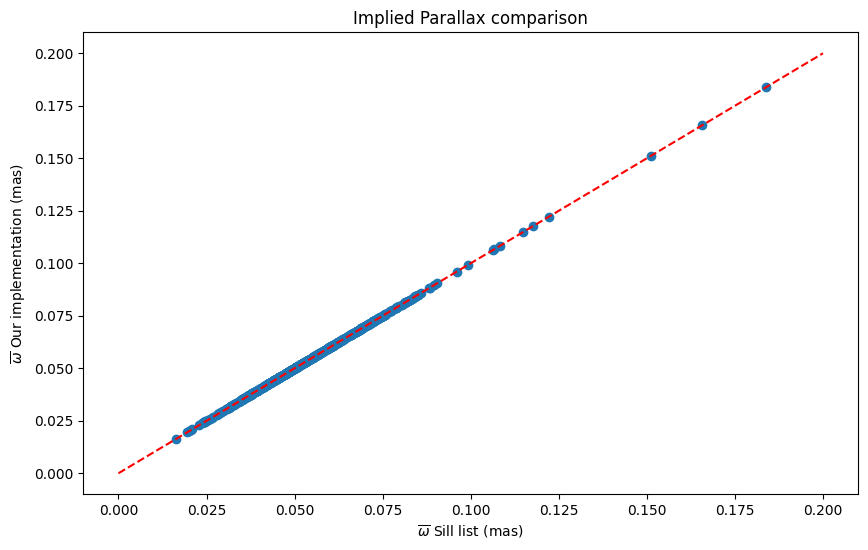

In [113]:
# Plot comparison between results parallax
plt.figure(figsize=(10, 6))
plt.scatter(plx_sill, plx_mas)
plt.xlabel('$ \overline{ \omega}$ Sill list (mas)')
plt.ylabel('$ \overline{ \omega}$ Our implementation (mas)')
x = np.linspace(0, 0.2, 100)
plt.plot(x,x, 'r--')
plt.title('Implied Parallax comparison')
plt.show()

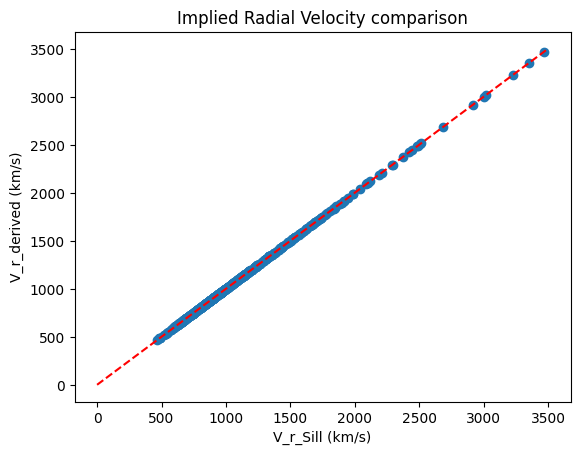

In [114]:
# Plot comparison between results V_r
plt.scatter(VR_sill, VR_kms)
plt.xlabel('V_r_Sill (km/s)')
plt.ylabel('V_r_derived (km/s)')
x = np.linspace(0, 3500, 100)
plt.plot(x,x, 'r--')
plt.title('Implied Radial Velocity comparison')
plt.show()

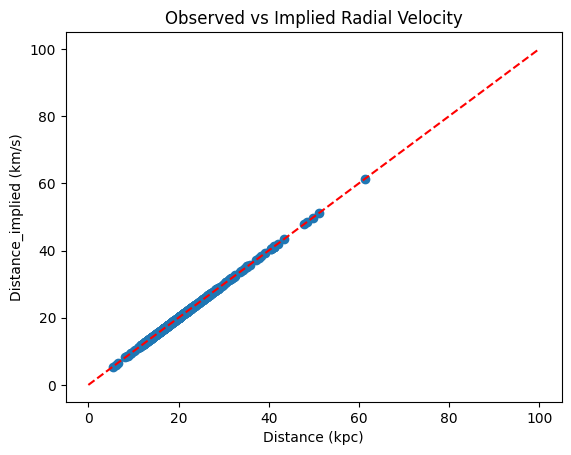

In [119]:
# Observed vs Implied distance
plt.scatter(gaia_results['D'], 1/plx_mas)
plt.xlabel('Distance (kpc)')
plt.ylabel('Distance_implied (km/s)')
x = np.linspace(0, 100, 100)
plt.plot(x,x, 'r--')
plt.title('Observed vs Implied Radial Velocity')
plt.show()


## See how it compares with observed candidates

In [121]:
# load observed data
sills_observed_candidates = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/observational_log.txt')

# merge with gaia data
sills_observed_candidates = sills_observed_candidates.merge(gaia_results, on='GaiaDR3_source_id', how='inner', suffixes=('_obs', ''))

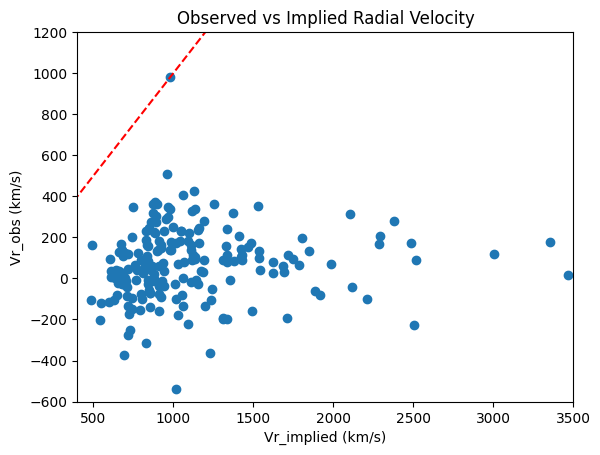

In [132]:
# implied radial velocity vs observed radial velocity
plt.scatter( sills_observed_candidates['Vr'], sills_observed_candidates['Vr_obs'])
plt.ylabel('Vr_obs (km/s)')
plt.xlabel('Vr_implied (km/s)')
x = np.linspace(-600, 3500, 100)
plt.plot(x,x, 'r--')
plt.title('Observed vs Implied Radial Velocity')

plt.ylim(-600, 1200)
plt.xlim(400, 3500)
plt.show()


In [ ]:
# test with stars from Gaia data in the solar neighborhood (within 200 pc)
# Load Gaia data


# Implement the selection criteria

## Inconsistent parallax
### $\overline{\omega}_I - \overline{\omega}_{gaia} < 2\sigma$

In [ ]:
def parallax_consistency(parallax, parallax_error, implied_parallax, implied_parallax_error, sigma= 2):
    """
    Check the consistency of the parallax values, if a star comes from the galactic center
    the observed and implied parallaxes should be consistent

    input:
        parallax: observed parallax in mas
        parallax_error: observed parallax error in mas
        implied_parallax: implied parallax in mas
        implied_parallax_error: implied parallax error in mas
        sigma: number of standard deviations to consider the parallax consistent
    output:
        bool: True if the parallax is consistent with the implied parallax

    """
    # check if the parallax is consistent with the implied parallax
    parallax_diff = np.abs(parallax - implied_parallax)
    parallax_diff_error = np.sqrt(parallax_error**2 + implied_parallax_error**2)
    return parallax_diff < sigma * parallax_diff_error

def is_fast(implied_radial_velocity, lower_limit = 800, upper_limit = 3500):
    """
    Check if the star is a fast star based on the implied radial velocity

    input:
        implied_radial_velocity: implied radial velocity in km/s

    output:
        bool: True if the star is fast

    """
    # check if the star is fast
    return implied_radial_velocity > lower_limit and implied_radial_velocity < upper_limit

def decent_astrometry(ruwe):
    """
    Check if the astrometry is decent based on the renormalized unit weight error

    input:
        ruwe: renormalized unit weight error

    output:
        bool: True if the astrometry is decent

    """
    return ruwe < 1.4

def distance_consistency(implied_distance, bailer_jones_distance, implied_distance_error, bailer_jones_distance_error, sigma = 2):
    """
    Check the consistency of the distance values, if a star comes from the galactic center
    the observed and implied distances should be consistent

    input:
        implied_distance: implied distance in kpc
        bailer_jones_distance: observed distance in kpc
        implied_distance_error: implied distance error in kpc
        bailer_jones_distance_error: observed distance error in kpc
        sigma: number of standard deviations to consider the distance consistent
    output:
        bool: True if the distance is consistent with the implied distance

    """
    # check if the distance is consistent with the implied distance
    distance_diff = np.abs(bailer_jones_distance - implied_distance)
    distance_diff_error = np.sqrt(bailer_jones_distance_error**2 + implied_distance_error**2)
    return distance_diff < sigma * distance_diff_error


def check_extinction(ra, dec, limit = 1.5):
    """
    Check if the star is affected by extinction

    input:
        ra: right ascension in degrees
        dec: declination in degrees
        limit: limit for the extinction in magnitudes

    output:
        bool: True if the star is affected by extinction

    """
    # check if the star is affected by extinction
    extinction = sfd(ra, dec, unit='degree')
    return extinction > limit


def is_main_sequence(bp_rp, M_g, implied_distance):
    """
    Check if the star is in the main sequence based on the color and absolute magnitude 
    computed from the implied distance

    input:
        bp_rp: color index
        gmag:  magnitude
        implied_distace: implied distance in kpc

    output:
        bool: True if the star is in the main sequence

    """

    # check if the star is in the main sequence
    return (-1.5 < M_g - 4.3*(bp_rp)) and(-1.5 < M_g - 4.3*(bp_rp))




def compute_absolute_magntiude(gmag, distance, extinction):
    """
    Compute the absolute magnitude of a star

    input:
        gmag: apparent magnitude
        distance: distance in kpc
        extinction: extinction in magnitudes

    output:
        float: absolute magnitude
    """
    return gmag - 5 * np.log10(distance * 1e3) + 5 - extinction



# load dust map sfd
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

# gaia extintion correction
def extinction_correction(catalog):
    """
    Compute the extinction correction for the stars in the catalog

    input:
        catalog: Gaia catalog

    output:
        catalog: Gaia catalog with the extinction correction A_G
    """
    # define skycoord object
    coords = SkyCoord(ra=catalog['ra'], dec=catalog['dec'], unit=(u.degree, u.degree), frame='icrs')

    # retrive extinction values E(B - V) from sfd
    ebv = sfd(coords)

    # compute the extinction in V band
    A_V = 3.1 * ebv

    # transform to gaia G_bp, G_rp and G bands using PARSEC extinction coefficients for EDR3
    A_G = 0.83627 * A_V
    A_bp = 1.08337 * A_V
    A_rp = 0.63439 * A_V


    # add corrected photometry to the catalog
    catalog['G_corr'] = catalog['phot_g_mean_mag'] - A_G
    catalog['bp_rp_corr'] = catalog['phot_bp_mean_mag'] - A_bp 
    catalog['bp_rp_corr'] = catalog['phot_rp_mean_mag'] - A_rp


    return catalog